In [1]:
%matplotlib inline
from matplotlib import pyplot
import sys
sys.path.insert(0,'/home/ernie/caffe2/build')

from caffe2.python import core, model_helper, net_drawer, workspace, brew
from caffe2.proto import caffe2_pb2
import caffe2.python.models.SSDNet as SSDNet
import numpy as np

In [2]:
def AddInput(model, batch_size, db, db_type):
    data, gt_label = model.net.AnnotationInput(
        [],["Annodata","gt_label"],batch_size = batch_size,
        db=db, db_type = db_type,scale = 300, crop = 300,
        use_gpu_transform = 0, mirror = 1, warp = 1, color = 1,
        use_caffe_datum = 1,
        interp_mode = ["LINEAR","AREA","NEAREST","CUBIC","LANCZOS4"],
        decode_threads=4
    )
    data_gpu = model.net.CopyCPUToGPU(data,'data_gpu')
    data_gpu = model.StopGradient(data_gpu, data_gpu)
    return data_gpu, gt_label

In [3]:
def AddSSDNetModel(model,data):
    mbox_layers = SSDNet.SSDNet(model,data)
    return mbox_layers

In [4]:
def AddConfReshape(model, conf, num_classes):
    model.net.Reshape([conf],["conf_reshape","shape_1"],shape=[-1,num_classes])
    model.net.Softmax("conf_reshape","conf_softmax")
    conf_softmax_flat=model.net.Reshape("conf_softmax",["conf_softmax_flat","shape_2"],shape=[1,-1])
    return conf_softmax_flat

In [5]:
def AddTrainingOperators(model, mbox_layers, gt_label):
    MultiboxInput = mbox_layers
   # MultiboxInput.append(gt_label)
    
    mbox_loc_cpu = model.net.CopyGPUToCPU(mbox_layers[0],'mbox_loc_cpu')
    mbox_conf_cpu = model.net.CopyGPUToCPU(mbox_layers[1],'mbox_conf_cpu')
   
    loc_pred,loc_gt,conf_pred,conf_gt=model.net.MultiboxLoss(
    [mbox_loc_cpu, mbox_conf_cpu, mbox_layers[2],gt_label],['loc_pred','loc_gt','conf_pred','conf_gt']
    )
   # loc_pred,loc_gt,conf_pred,conf_gt=model.net.MultiboxLoss(
   # [mbox_layers[0], mbox_layers[1], mbox_layers[2],gt_label],['loc_pred','loc_gt','conf_pred','conf_gt']
   # )
    loc_pred_gpu = model.net.CopyCPUToGPU(loc_pred,'loc_pred_gpu')
    loc_gt_gpu = model.net.CopyCPUToGPU(loc_gt,'loc_gt_gpu')
    conf_pred_gpu = model.net.CopyCPUToGPU(conf_pred,'conf_pred_gpu')
    conf_gt_gpu = model.net.CopyCPUToGPU(conf_gt,'conf_gt_gpu')
    SmoothL1Loss = model.net.SmoothL1Loss([loc_pred_gpu, loc_gt_gpu],'SmoothL1Loss')
    P,SoftmaxWithLoss = model.net.SoftmaxWithLoss([conf_pred_gpu,conf_gt_gpu],["P","SoftmaxWithLoss"])
    model.AddGradientOperators([SmoothL1Loss,SoftmaxWithLoss])
    
    ITER = brew.iter(model,"iter")
  #  ITER = model.param_init_net.ConstantFill([],'ITER',shape=[1],value=0,dtype=core.DataType.INT32)
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.001,policy="step",stepsize=80000,gamma=0.1
        )
    ONE = model.param_init_net.ConstantFill([],"ONE",shape=[1],value=1.0)
    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR],param)

In [6]:
train_model = model_helper.ModelHelper(name="ssd_train")
data, gt_label = AddInput(train_model, batch_size=1, 
                         db='/home/ernie/ssd/caffe/examples/VOC0712/VOC0712_trainval_lmdb',
                         db_type='lmdb')
mbox_layers = AddSSDNetModel(train_model, data)
AddTrainingOperators(train_model, mbox_layers, gt_label)
#train_model.RunAllOnGPU()
deploy_model = model_helper.ModelHelper(name="ssd_deploy", init_params=False)
mbox_layers = AddSSDNetModel(deploy_model, "data")
conf_softmax_flat = AddConfReshape(deploy_model, mbox_layers[1], 21)
mbox_layers[1] = 'conf_softmax_flat'
deploy_model.net.DetectionOutput(mbox_layers,["detection_out"]
                                ,num_classes=21,nms_threshold=0.45,keep_top_k=200,top_k_=400)
net_def = caffe2_pb2.NetDef()
with open('/home/ernie/caffemodel/VGG16_init_net.pb','r') as f:
    net_def.ParseFromString(f.read())
workspace.RunNetOnce(net_def)

True

In [7]:
def deviceOpts(cpu_or_cuda):
    device_opts = caffe2_pb2.DeviceOption()
    if cpu_or_cuda == 'cpu':
        device_opts.device_type = caffe2_pb2.CPU
    elif cpu_or_cuda == 'cuda':
        device_opts.device_type = caffe2_pb2.CUDA
        device_opts.cuda_gpu_id = 0
    return device_opts

for op in train_model.net.Proto().op:
    if op.type =='AnnotationInput':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'CopyCPUToGPU':
        op.device_option.CopyFrom(deviceOpts('cuda'))
    elif op.type == 'Concat' and op.output[0] == 'mbox_priorbox':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'MultiboxLoss':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'MultiboxLossGradient':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    else:
        op.device_option.CopyFrom(deviceOpts('cuda'))

In [ ]:
for op in train_model.param_init_net.Proto().op:
    if op.output[0] == "iter":
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.output[0] == "ONE":
        op.device_option.CopyFrom(deviceOpts('cuda'))
    else: op.device_option.CopyFrom(deviceOpts('cuda'))
 #   if op.output[0] =='ITER':
  #      op.device_option.CopyFrom(deviceOpts('cpu'))

In [ ]:
losses_ = []
def UpdateSmoothedLoss(loss, iter_, average_loss, smoothed_loss):
    if len(losses_) < average_loss:
        losses_.append(loss)
        size = len(losses_)
        smoothed_loss = (smoothed_loss * (size - 1) + loss) / size
    else:
        idx = iter_ % average_loss
        smoothed_loss = smoothed_loss + (loss - losses_[idx]) / average_loss
        losses_[idx] = loss
    return smoothed_loss
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters = 200000
loc_loss = np.zeros(total_iters)
conf_loss = np.zeros(total_iters)
smoothed_loss = 0
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    loc_loss[i] = workspace.FetchBlob('SmoothL1Loss')
    conf_loss[i] = workspace.FetchBlob('SoftmaxWithLoss')
    smoothed_loss = UpdateSmoothedLoss(loc_loss[i]+conf_loss[i], i ,10,smoothed_loss)
    if i%10000==0:
        print 'iters = ',i,'loss = ',smoothed_loss,'smooth = ',loc_loss[i],'softmax = ',conf_loss[i]

iters =  0 loss =  7.47075939178 smooth =  2.44054412842 softmax =  5.03021526337
iters =  10000 loss =  4.29365043044 smooth =  2.37341213226 softmax =  1.51603281498
iters =  20000 loss =  3.27640112638 smooth =  1.75418841839 softmax =  1.34704339504
iters =  30000 loss =  3.17987504303 smooth =  2.64918851852 softmax =  1.32556664944
iters =  40000 loss =  3.33160598278 smooth =  0.946695029736 softmax =  1.49222922325
iters =  50000 loss =  3.20385146141 smooth =  0.719152331352 softmax =  0.977765679359
iters =  60000 loss =  2.94178192466 smooth =  2.29606699944 softmax =  1.12712156773
iters =  70000 loss =  3.56263659 smooth =  0.866911649704 softmax =  1.38362789154
iters =  80000 loss =  2.49435947537 smooth =  1.02927398682 softmax =  1.25192952156
iters =  90000 loss =  2.41948829889 smooth =  1.31675136089 softmax =  1.13092637062
iters =  100000 loss =  2.55670156181 smooth =  1.56566143036 softmax =  1.26909816265
iters =  110000 loss =  2.59293608218 smooth =  0.853954

In [10]:
for op in train_model.net.Proto().op:
    print op

output: "Annodata"
output: "gt_label"
name: ""
type: "AnnotationInput"
arg {
  name: "scale"
  i: 300
}
arg {
  name: "use_caffe_datum"
  i: 1
}
arg {
  name: "color"
  i: 1
}
arg {
  name: "use_gpu_transform"
  i: 0
}
arg {
  name: "db"
  s: "/home/ernie/data/VOCdevkit/test/lmdb/test_trainval_lmdb"
}
arg {
  name: "crop"
  i: 300
}
arg {
  name: "interp_mode"
  strings: "LINEAR"
  strings: "AREA"
  strings: "NEAREST"
  strings: "CUBIC"
  strings: "LANCZOS4"
}
arg {
  name: "warp"
  i: 1
}
arg {
  name: "batch_size"
  i: 1
}
arg {
  name: "mirror"
  i: 1
}
arg {
  name: "decode_threads"
  i: 1
}
arg {
  name: "db_type"
  s: "lmdb"
}
device_option {
  device_type: 0
}

input: "Annodata"
output: "data_gpu"
name: ""
type: "CopyCPUToGPU"
device_option {
  device_type: 1
  cuda_gpu_id: 0
}

input: "data_gpu"
output: "data_gpu"
name: ""
type: "StopGradient"
device_option {
  device_type: 1
  cuda_gpu_id: 0
}

input: "data_gpu"
input: "conv1_1_w"
input: "conv1_1_b"
output: "conv1_1"
name: ""


In [11]:
#conf_pred_gpu_grad = workspace.FetchBlob('conf_pred_gpu')
loc_pred_gpu = workspace.FetchBlob('loc_pred_gpu')
loc_gt_gpu = workspace.FetchBlob('loc_gt_gpu')
print loc_pred_gpu
print loc_gt_gpu
loc_pred_gpu_grad = workspace.FetchBlob('loc_pred_gpu_grad')
print loc_pred_gpu_grad

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
[[ 0.60871643  0.8048045  -0.21602812  1.46536458  0.50387061  0.66618419
  -1.16119325  0.52019912  0.8608551   0.56908274  1.51684046 -0.26750305
   1.05432785  0.46465501  2.5305028  -1.28116584 -1.98189223  0.66618419
  -1.16119361  0.52019912 -3.38603187  0.56908274  1.5168395  -0.26750305
   0.60871643 -2.19819832 -0.21602812  1.46536458  0.50387061 -1.81957734
  -1.16119325  0.52019912  0.8608551  -1.55436087  1.51684046 -0.26750368
  -1.22900796  0.96296155 -2.10635877 -0.42496625]]
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   nan   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   nan   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


In [12]:
#test_net = core.Net("ssd_test")
#deploy_model = model_helper.ModelHelper(name="ssd_deploy", init_params=False)
#mbox_layers = AddSSDNetModel(deploy_model, 'data')
#conf_softmax_flat = AddConfReshape(deploy_model, mbox_layers[1], 21)
#mbox_layers[1] = "conf_softmax_flat"
#deploy_model.net.DetectionOutput(mbox_layers,["detection_out"]
#                                ,num_classes=21,nms_threshold=0.45,keep_top_k=200,top_k_=400)
for op in deploy_model.net.Proto().op:
    if op.type =='AnnotationInput':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'CopyCPUToGPU':
        op.device_option.CopyFrom(deviceOpts('cuda'))
    elif op.type == 'Concat' and op.output[0] == 'mbox_priorbox':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'MultiboxLoss':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.type == 'MultiboxLossGradient':
        op.device_option.CopyFrom(deviceOpts('cpu'))
    else:
        op.device_option.CopyFrom(deviceOpts('cuda'))
for op in deploy_model.param_init_net.Proto().op:
    if op.output[0] == "iter":
        op.device_option.CopyFrom(deviceOpts('cpu'))
    elif op.output[0] == "ONE":
        op.device_option.CopyFrom(deviceOpts('cuda'))
    else: op.device_option.CopyFrom(deviceOpts('cuda'))
data=np.load("transformed_image.npy")
data = data[np.newaxis, :, :, :]
workspace.FeedBlob('data',data,deviceOpts('cuda'))
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)
workspace.RunNet(deploy_model.net,1)
detections = workspace.FetchBlob('detection_out')
print detections.shape

(1, 1, 200, 7)


323 481
0.782492 0.720235 0.925875 0.918501
376 233 445 297
0.530026 0.123558 0.911086 1.00354
255 40 438 324
0.701647 0.0826552 0.975371 0.984327
337 27 469 318


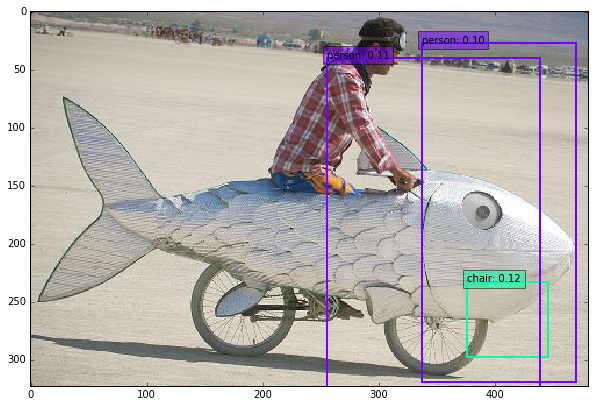

In [13]:
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]
#import numpy as np
import skimage.io
from scipy.ndimage import zoom
from skimage.transform import resize
#import matplotlib.pyplot as plt

pyplot.rcParams['figure.figsize'] = (10, 10)
pyplot.rcParams['image.interpolation'] = 'nearest'
pyplot.rcParams['image.cmap'] = 'gray'
def load_image(filename, color=True):
    img = skimage.img_as_float(skimage.io.imread(filename, as_grey=not color)).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        if color:
            img = np.tile(img, (1, 1, 3))
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img
image = load_image('./fish-bike.jpg')
# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.1]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]
CLASSES = ('__background__', 
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

pyplot.imshow(image)
currentAxis = pyplot.gca()
colors = pyplot.cm.hsv(np.linspace(0, 1, len(CLASSES))).tolist()
print image.shape[0],image.shape[1]
for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    print top_xmin[i],top_ymin[i],top_xmax[i],top_ymax[i]
    print xmin,ymin,xmax,ymax
    score = top_conf[i]
    label = int(top_label_indices[i])
    display_txt = '%s: %.2f'%(CLASSES[label], score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(pyplot.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})